In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess
import random

cheated_0 = Events('CheatedRecoFile_0_new.root')

In [2]:
def primary(events, idx_array):
    # find nu_vtx and particle_vtx of all indices in idx_array
    nu_vtx_w = events.neutrino_vtx_w[idx_array]
    nu_vtx_x = events.neutrino_vtx_x[idx_array]
    idx_w_vtx = events.reco_particle_vtx_w[idx_array]
    idx_x_vtx = events.reco_particle_vtx_x[idx_array]

    w_distances = idx_w_vtx - nu_vtx_w
    x_distances = idx_x_vtx - nu_vtx_x

    abs_distances = np.sqrt(w_distances**2 + x_distances**2)

    # if distances are empty
    if len(abs_distances) != 0:
        primary = np.argmin(abs_distances)
        return idx_array[primary]
    else: return None

def largest_hits(events, idx_array):
    w_hits = events.reco_hits_w[idx_array]
    lengths = [len(hit_set) for hit_set in w_hits]
    return idx_array[np.argmax(lengths)]
    

def candidates(events, hits_cutoff=15):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1

    # Gets an array of unique events and their corresponding indices, example: [[1, 2, 3, 4], [5, 6, 7], ...]
    slices = np.split(np.arange(len(identifiers)), change_indices)
    
    # some pdg codes
    muon = [-13, 13]
    electron = [-11, 11]
    
    candidate_dict = {
        'CCnu_e': [],
        'CCnu_mu': [],
    }

    # for truth and confusion testing
    candidate_list = []

    for s in slices:
        prim = primary(events, s)
        if events.mc_pdg[prim] in muon:
            candidate_dict['CCnu_mu'].append(prim)
            candidate_list.append(prim)
        elif events.mc_pdg[prim] in electron:
            candidate_dict['CCnu_e'].append(prim)
            candidate_list.append(prim)
        else: candidate_list.append(largest_hits(events, s))

    return candidate_dict, candidate_list

candidates_0 = candidates(cheated_0)[1]
print(f'{candidates_0[:50]}...\n')
print(f'{len(candidates_0)} candidates identified within the hits quality cut')

[1, 5, 108, 152, 161, 165, 260, 279, 655, 658, 685, 804, 819, 957, 1097, 1182, 1397, 1462, 1470, 1478, 1554, 1562, 2075, 2094, 2109, 2141, 2181, 2191, 2207, 2213, 2233, 2273, 2300, 2531, 2540, 2616, 2706, 2717, 2803, 2820, 2850, 2906, 2907, 2932, 3017, 3027, 3046, 3179, 3287, 3343]...

9505 candidates identified within the hits quality cut


In [3]:
def true_category(events, hits_cutoff=15):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1

    # Takes first idx of each event, just for bool values.
    slices = [arr[0] for arr in np.split(np.arange(len(identifiers)), change_indices)]

    # Find boolean arrays for each CC
    CCnue_bool = events.is_nue[slices]
    CCnumu_bool = events.is_numu[slices]

    categories = np.zeros_like(slices, dtype=object)  # Change dtype to object to store strings

    for i in range(len(slices)):
        if CCnue_bool[i]:
            categories[i] = 'CCnu_e'
        elif CCnumu_bool[i]:
            categories[i] = 'CCnu_mu'
        else:
            categories[i] = 'NCnu_x'

    return categories

true_categories_0 = true_category(cheated_0)
print(f'{true_categories_0[:10]}...')

['CCnu_mu' 'NCnu_x' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu'
 'NCnu_x' 'CCnu_mu' 'CCnu_mu']...


In [4]:
predicted_0 = np.zeros_like(candidates_0, dtype=object)

for i, j in enumerate(candidates_0):
    if cheated_0.mc_pdg[j] in [-13, 13]:
        predicted_0[i] = 'CCnu_mu'
    elif cheated_0.mc_pdg[j] in [-11, 11]:
        predicted_0[i] = 'CCnu_e'
    else: predicted_0[i] = 'NCnu_x'

print(predicted_0[:10])

['CCnu_mu' 'NCnu_x' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu' 'CCnu_mu'
 'NCnu_x' 'CCnu_mu' 'NCnu_x']


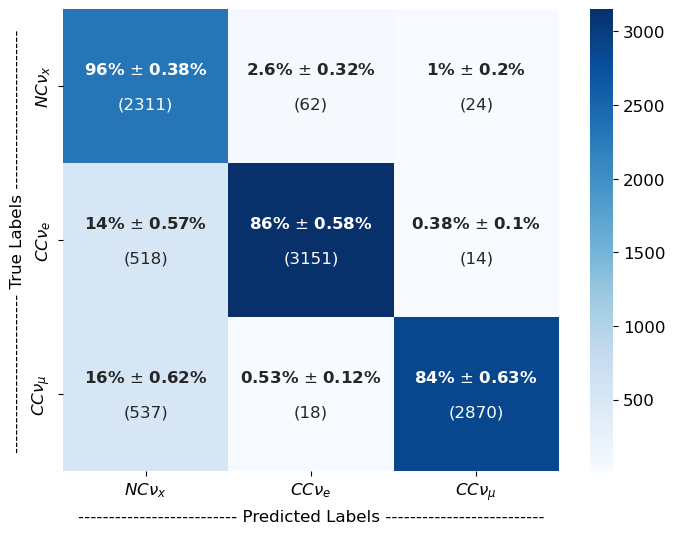

87.65912677538138
0.33736145020084213


In [5]:
# make a confusion matrix of truth vs precicted
plt.rcParams.update({'font.size': 12})
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
particle_labels = ['NCnu_x', 'CCnu_e', 'CCnu_mu']
# Generate confusion matrix
cm = confusion_matrix(true_categories_0, predicted_0, labels=particle_labels)

def eff(m, n):
    return m/n

def uncertainty(m, n):
    return np.sqrt(eff(m, n) * (1 - eff(m, n))/n)

# Create efficiency and uncertainty arrays
eff_matrix = np.zeros_like(cm, dtype=float)
uncertainty_matrix = np.zeros_like(cm, dtype=float)

# Fill the matrices with efficiency and uncertainty
for i in range(len(particle_labels)):
    for j in range(len(particle_labels)):
        total = np.sum(cm[i])  # Total for the true class (row sum)
        true_positive = cm[i, j]  # True positives (diagonal element)
        
        if total > 0:
            eff_matrix[i, j] = eff(true_positive, total)
            uncertainty_matrix[i, j] = uncertainty(true_positive, total)

# Create formatted labels that include efficiency + uncertainty and tally
formatted_values = []
for i in range(len(particle_labels)):
    row = []
    for j in range(len(particle_labels)):
        eff_val = r'$\mathbf{' + f'{eff_matrix[i, j]*100:.2g}' + r'\%}$'
        unc_val = r'$\mathbf{' + f'{uncertainty_matrix[i, j]*100:.2g}' + r'\%}$'
        tally = f'({cm[i, j]})'  # Raw count
        
        # Combine efficiency, uncertainty, and tally
        formatted_string = f'{eff_val} $\pm$ {unc_val}\n\n{tally}'
        row.append(formatted_string)
    formatted_values.append(row)

# Plotting the confusion matrix with efficiency, uncertainty, and tally
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=formatted_values, fmt='', cmap='Blues', 
            xticklabels=[r'$NC\nu_x$', r'$CC\nu_e$', r'$CC\nu_\mu$'], yticklabels=[r'$NC\nu_x$', r'$CC\nu_e$', r'$CC\nu_\mu$'])

plt.xlabel('-------------------------- Predicted Labels --------------------------')
plt.ylabel('-------------------------- True Labels --------------------------')
plt.show()

print(eff(np.trace(cm), np.sum(cm))*100)
print(uncertainty(np.trace(cm), np.sum(cm))*100)

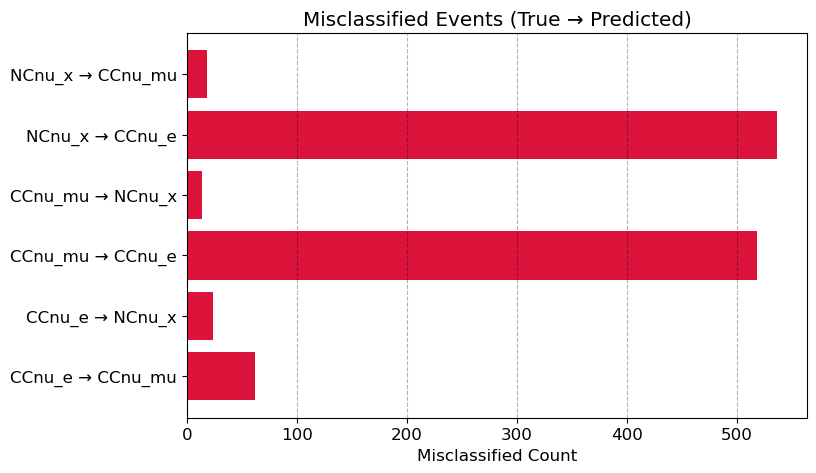

In [6]:
import pandas as pd

labels = ['CCnu_e', 'CCnu_mu', 'NCnu_x']
# Iterate over all the true and predicted labels
false_classifications = []
for true_idx, true_label in enumerate(labels):
    for pred_idx, pred_label in enumerate(labels):
        if true_idx != pred_idx:  # Only consider misclassifications
            # Get the indices where the prediction is wrong
            count = cm[true_idx, pred_idx]
            if count > 0:
                false_classifications.append((true_label, pred_label, count))

# Convert to a DataFrame for better readability
false_df = pd.DataFrame(false_classifications, columns=['True Label', 'Predicted Label', 'Count'])

# Ensure there are misclassifications before plotting
if not false_df.empty:
    plt.figure(figsize=(8, 5))
    plt.barh(false_df["True Label"] + " → " + false_df["Predicted Label"], false_df["Count"], color='crimson')
    plt.xlabel("Misclassified Count")
    plt.title("Misclassified Events (True → Predicted)")
    plt.grid(axis="x", linestyle="--", alpha=0.3, c='k')
    plt.show()
else:
    print("No misclassifications found!")


In [7]:
misclassification_indices = {
    ('CCnu_e', 'CCnu_mu'): [],
    ('CCnu_e', 'NCnu_x'): [],
    ('CCnu_mu', 'CCnu_e'): [],
    ('CCnu_mu', 'NCnu_x'): [],
    ('NCnu_x', 'CCnu_e'): [],
    ('NCnu_x', 'CCnu_mu'): []
}

# Iterate over all the true and predicted categories
for idx, (true_category, predicted_category) in enumerate(zip(true_categories_0, predicted_0)):
    if true_category != predicted_category:  # Misclassification
        # Append the index to the corresponding list in the dictionary
        misclassification_indices[(true_category, predicted_category)].append(idx)

In [8]:
mc_pdg_dict = {
    -2212: "Anti proton",
    -321: "K-",
    -211: "π-",
    -13: "μ-",
    -11: "e- ",
    11: "e+",
    13: "μ+",
    22: "γ",
    211: "π+",
    321: "K+",
    2212: "proton",
    3112: "Σ-",
    3222: "Σ+",
    
    # Light Nuclei
    1000010020: "Deuteron",
    1000010030: "Triton",
    1000010040: "Helium-3",
    1000020030: "Helium-3 (alt)",
    1000020040: "Alpha Particle (He-4)",
    1000020060: "Helium-6",
    1000030060: "Lithium-6",
    1000030070: "Lithium-7",
    1000030080: "Lithium-8",
    1000040080: "Beryllium-8",
    1000040090: "Beryllium-9",
    1000040100: "Beryllium-10",
    1000070150: "Nitrogen-15",
    1000070160: "Nitrogen-16",
    1000070170: "Nitrogen-17",
    
    # Heavier Nuclei
    1000100200: "Neon-20",
    1000100220: "Neon-22",
    1000110230: "Sodium-23",
    1000120240: "Magnesium-24",
    1000120250: "Magnesium-25",
    1000120260: "Magnesium-26",
    1000120270: "Magnesium-27",
    1000120280: "Magnesium-28",
    1000130260: "Aluminum-26",
    1000130270: "Aluminum-27",
    1000130280: "Aluminum-28",
    1000130290: "Aluminum-29",
    1000140270: "Silicon-27",
    1000140280: "Silicon-28",
    1000140290: "Silicon-29",
    1000140300: "Silicon-30",
    1000140310: "Silicon-31",
    1000140320: "Silicon-32",
    1000140330: "Silicon-33",
    1000140340: "Silicon-34",
    1000150300: "Phosphorus-30",
    1000150310: "Phosphorus-31",
    1000150320: "Phosphorus-32",
    1000150330: "Phosphorus-33",
    1000150340: "Phosphorus-34",
    1000150350: "Phosphorus-35",
    1000150360: "Phosphorus-36",
    1000150370: "Phosphorus-37",
    1000160310: "Sulfur-31",
    1000160320: "Sulfur-32",
    1000160330: "Sulfur-33",
    1000160340: "Sulfur-34",
    1000160350: "Sulfur-35",
    1000160360: "Sulfur-36",
    1000160370: "Sulfur-37",
    1000160380: "Sulfur-38",
    1000160390: "Sulfur-39",
    1000170340: "Chlorine-34",
    1000170350: "Chlorine-35",
    1000170360: "Chlorine-36",
    1000170370: "Chlorine-37",
    1000170380: "Chlorine-38",
    1000170390: "Chlorine-39",
    1000170400: "Chlorine-40",
    1000180350: "Argon-35",
    1000180360: "Argon-36",
    1000180370: "Argon-37",
    1000180380: "Argon-38",
    1000180390: "Argon-39",
    1000180400: "Argon-40",
    1000180410: "Argon-41",
    1000190380: "Potassium-38",
    1000190390: "Potassium-39",
    1000190400: "Potassium-40",
    1000190410: "Potassium-41",
}

In [9]:
def plot_event(events, event_number):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]

    w_hits = np.array(events.reco_hits_w[event_indices], dtype=object)
    x_hits = np.array(events.reco_hits_x_w[event_indices], dtype=object)
    event_pdgs = np.array(events.mc_pdg[event_indices])

    unique_pdgs = np.unique(event_pdgs)

    plt.figure(figsize=(12, 8))

    for pdg in unique_pdgs:
        mask = event_pdgs == pdg
        w = np.concatenate(w_hits[mask])
        x = np.concatenate(x_hits[mask])

        if len(w_hits[mask]) == 1:
            plt.scatter(w, x, s=3, label=mc_pdg_dict[pdg])
        else: plt.scatter(w, x, s=3, label=f'{mc_pdg_dict[pdg]} ({len(w_hits[mask])}x)')

    # Neutrino vertex
    w_vtx = events.neutrino_vtx_w[event_indices[0]]
    x_vtx = events.neutrino_vtx_x[event_indices[0]]

    classifier = 'NCnu_x'
    if events.is_nue[event_indices[0]]:
        classifier = 'CCnu_e'
    elif events.is_numu[event_indices[0]]:
        classifier = 'CCnu_mu'
    elif events.is_cc[event_indices[0]]:
        classifier = 'CC'

    plt.scatter(w_vtx, x_vtx, marker='*', facecolors='none', edgecolors='b', s=50, label='Neutrino Vertex')

    plt.title(f'W View for Event Number {event_number}. Event is a true {classifier}')
    plt.ylabel('x (cm)')
    plt.xlabel('w (cm)')
    plt.legend()
    plt.grid(True)
    plt.show()

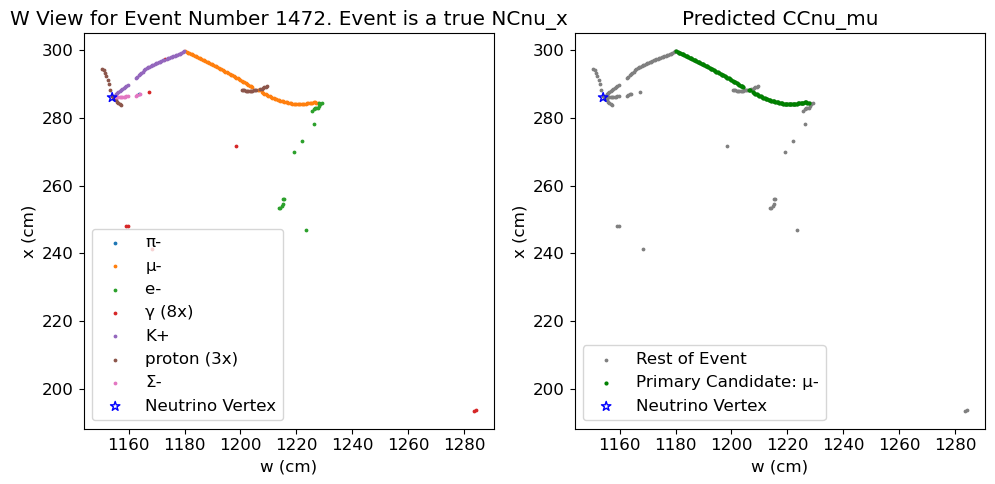

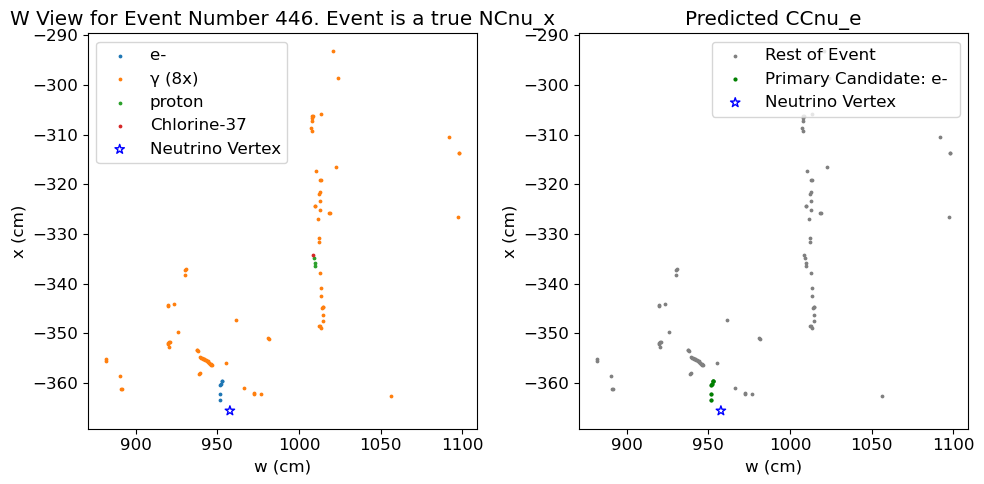

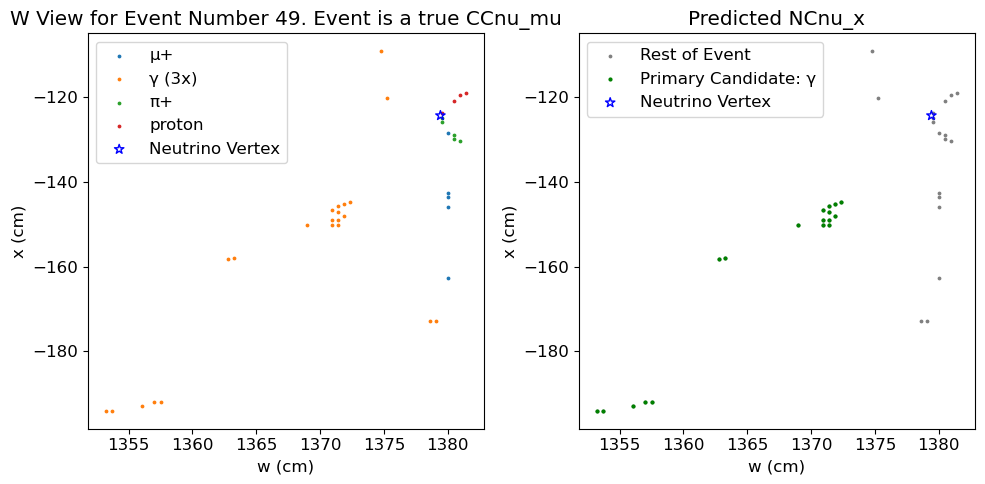

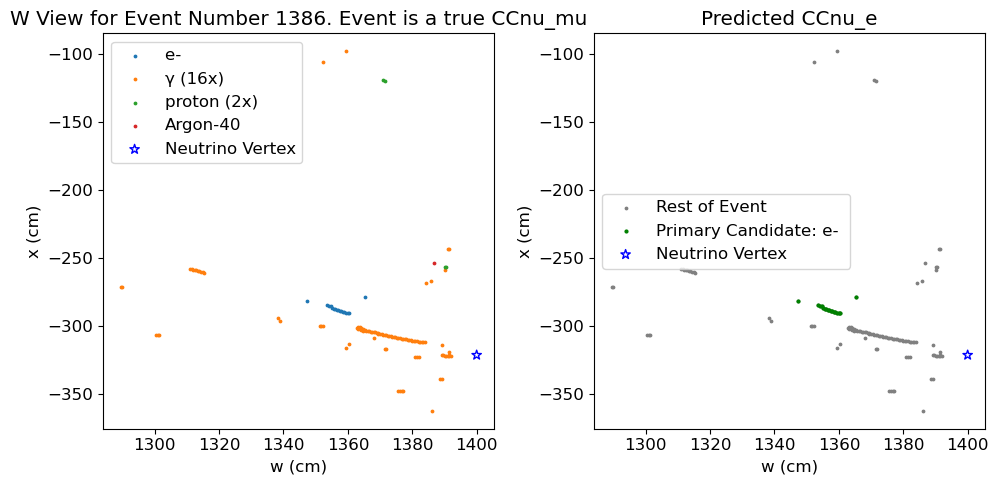

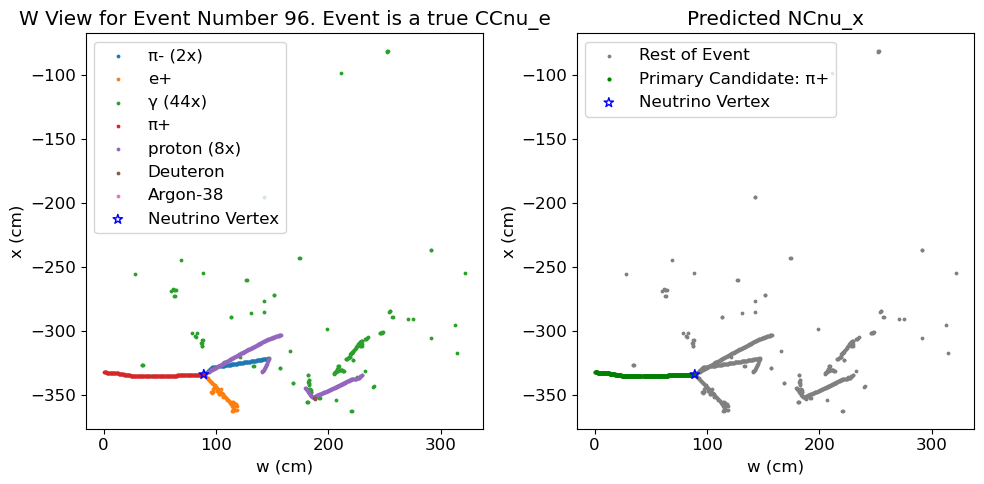

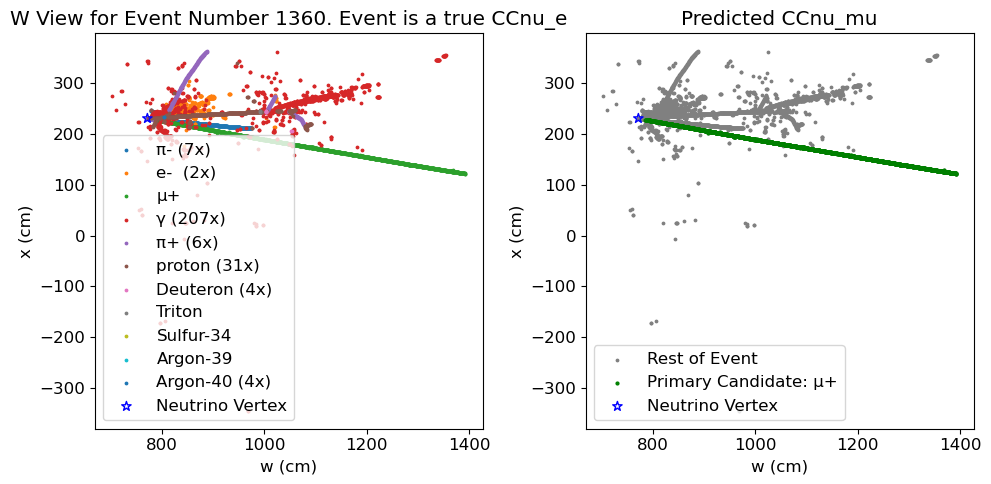

In [10]:
def CL_finder(events, event_number, show_plot=False, debug=False):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1

    # Gets an array of unique events and their corresponding indices, example: [[1, 2, 3, 4], [5, 6, 7], ...]
    slices = np.split(np.arange(len(identifiers)), change_indices)
    event_indices = slices[event_number]
    pdg_vals = events.mc_pdg[event_indices]

    # some pdg codes
    muon = [-13, 13]
    electron = [-11, 11]

    candidate_idx = primary(events, event_indices)
    if events.mc_pdg[candidate_idx] not in [-13, -11, 11, 13]:
        candidate_idx = largest_hits(events, event_indices)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    w_hits = np.array(events.reco_hits_w[event_indices], dtype=object)
    x_hits = np.array(events.reco_hits_x_w[event_indices], dtype=object)
    event_pdgs = np.array(events.mc_pdg[event_indices])

    unique_pdgs = np.unique(event_pdgs)

    for pdg in unique_pdgs:
        mask = event_pdgs == pdg
        w = np.concatenate(w_hits[mask])
        x = np.concatenate(x_hits[mask])

        if len(w_hits[mask]) == 1:
            ax[0].scatter(w, x, s=3, label=mc_pdg_dict[pdg])
        else: ax[0].scatter(w, x, s=3, label=f'{mc_pdg_dict[pdg]} ({len(w_hits[mask])}x)')

    # Neutrino vertex
    w_vtx = events.neutrino_vtx_w[event_indices[0]]
    x_vtx = events.neutrino_vtx_x[event_indices[0]]

    classifier = 'NCnu_x'
    if events.is_nue[event_indices[0]]:
        classifier = 'CCnu_e'
    elif events.is_numu[event_indices[0]]:
        classifier = 'CCnu_mu'
    elif events.is_cc[event_indices[0]]:
        classifier = 'CC'

    ax[0].scatter(w_vtx, x_vtx, marker='*', facecolors='none', edgecolors='b', s=50, label='Neutrino Vertex')

    ax[0].set_title(f'W View for Event Number {event_number}. Event is a true {classifier}')
    ax[0].set_ylabel('x (cm)')
    ax[0].set_xlabel('w (cm)')
    ax[0].legend()

    pred_class = 'NCnu_x'
    if events.mc_pdg[candidate_idx] in [-13, 13]:
        pred_class = 'CCnu_mu'
    elif events.mc_pdg[candidate_idx] in [-11, 11]:
        pred_class = 'CCnu_e'
    # Plot data on the second subplot
    ax[1].scatter(np.concatenate(w_hits), np.concatenate(x_hits), s=3, c='grey', label='Rest of Event')
    ax[1].scatter(events.reco_hits_w[candidate_idx], events.reco_hits_x_w[candidate_idx], s=4, c='g', label=f'Primary Candidate: {mc_pdg_dict[events.mc_pdg[candidate_idx]]}')
    ax[1].scatter(w_vtx, x_vtx, marker='*', facecolors='none', edgecolors='b', s=50, label='Neutrino Vertex')
    ax[1].set_title(f'Predicted {pred_class}')
    ax[1].set_ylabel('x (cm)')
    ax[1].set_xlabel('w (cm)')
    ax[1].legend()
    
    # Show the figure
    plt.tight_layout()
    plt.show()

# get an example of each misclassification
CL_finder(cheated_0, misclassification_indices[('NCnu_x', 'CCnu_mu')][4], show_plot=True)
CL_finder(cheated_0, misclassification_indices[('NCnu_x', 'CCnu_e')][3], show_plot=True)
CL_finder(cheated_0, misclassification_indices[('CCnu_mu', 'NCnu_x')][6], show_plot=True)
CL_finder(cheated_0, misclassification_indices[('CCnu_mu', 'CCnu_e')][1], show_plot=True)
CL_finder(cheated_0, misclassification_indices[('CCnu_e', 'NCnu_x')][0], show_plot=True)
CL_finder(cheated_0, misclassification_indices[('CCnu_e', 'CCnu_mu')][2], show_plot=True)

In [11]:
def CL_hits_per_event(events, idx_array):
    candidate_idx = primary(events, idx_array)
    if events.mc_pdg[candidate_idx] not in [-13, -11, 11, 13]:
        candidate_idx = largest_hits(events, idx_array)

    CL_size = len(events.reco_hits_w[candidate_idx])
    event_size = len(np.concatenate(events.reco_hits_w[idx_array]))

    if event_size == 0:
        return 0

    return CL_size / event_size

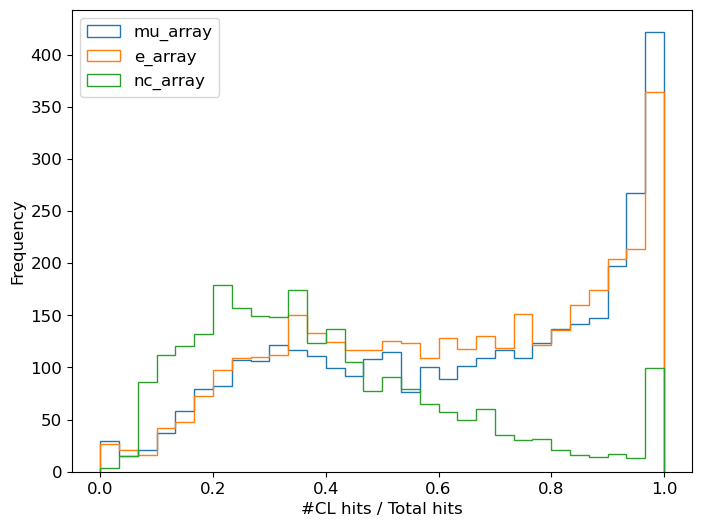

In [12]:
identifiers = cheated_0.event_number
change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
slices = np.split(np.arange(len(identifiers)), change_indices)

mu_array = np.array([])
e_array = np.array([])
nc_array = np.array([])

for s in slices:
    x = CL_hits_per_event(cheated_0, s)
    if cheated_0.is_numu[s[0]]:
        mu_array = np.append(mu_array, x)
    elif cheated_0.is_nue[s[0]]:
        e_array = np.append(e_array, x)
    else: nc_array = np.append(nc_array, x)

plt.figure(figsize=(8,6))
plt.hist(mu_array, bins=30, histtype='step', label='mu_array')
plt.hist(e_array, bins=30, histtype='step', label='e_array')
plt.hist(nc_array, bins=30, histtype='step', label='nc_array')
plt.xlabel('#CL hits / Total hits')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [13]:
def hits_per_event(events, idx_array, candidate_idx): # idx here is the "true candidate", to be selected later
    CL_size = len(events.reco_hits_w[candidate_idx])
    event_size = len(np.concatenate(events.reco_hits_w[idx_array]))

    if event_size == 0:
        return 0

    return CL_size / event_size

def return_slices_and_true_candidate(events):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    slices = np.split(np.arange(len(identifiers)), change_indices)

    candidates = []

    for i, s in enumerate(slices):
        pdgs = events.mc_pdg[s]
        if events.is_nue[s[0]]:
            mask = (pdgs == -11) | (pdgs == 11)
            idx = s[mask]
            candidates.append(primary(events, idx))
        elif events.is_numu[s[0]]:
            mask = (pdgs == -13) | (pdgs == 13)
            idx = s[mask]
            candidates.append(primary(events, idx))
        else: 
            candidates.append(largest_hits(events, s))
    return slices, candidates

In [14]:
def histogram(events, func):
    slices, candidates = return_slices_and_true_candidate(events)
    
    # Use lists for better performance in loops
    e = []
    mu = []
    nc = []

    # Loop through slices and candidates
    for i, j in zip(slices, candidates):
        if j == None: # sometimes we get the error where say: a nu_mu event has no muons.
            continue
        val = func(events, i, j)
        if events.is_nue[j]:
            e.append(val)  # Append to list
        elif events.is_numu[j]:
            mu.append(val)  # Append to list
        else:
            nc.append(val)  # Append to list

    # Convert lists to arrays at the end (when plotting)
    e = np.array(e)
    mu = np.array(mu)
    nc = np.array(nc)

    # Plot histograms
    plt.figure(figsize=(8,6))
    plt.hist(mu, bins=30, histtype='step', label='CCnu_mu')
    plt.hist(e, bins=30, histtype='step', label='CCnu_e')
    plt.hist(nc, bins=30, histtype='step', label='NC')

    # Labels and legend
    plt.xlabel('#CL hits / Total hits')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

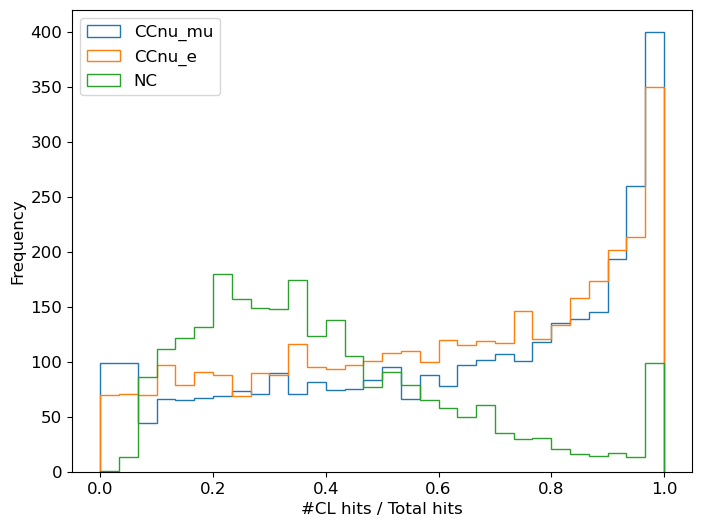

In [15]:
histogram(cheated_0, hits_per_event)

In [16]:
def adc_ratio(events, idx_array, candidate_idx):
    adcs = np.concatenate(events.reco_adcs_w[idx_array])
    adc_cl = events.reco_adcs_w[candidate_idx]
    return np.sum(adc_cl) / np.sum(adcs)

def line_ratio(events, idx_array, candidate_idx):
    w_hits = np.array(events.reco_hits_w[event_idx])
    x_hits = np.array(events.reco_hits_x_w[event_idx])

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
    
        # Calculate differences between consecutive points
        dx = np.diff(w_hits)
        dy = np.diff(x_hits)
    
        # Compute segment lengths
        segment_lengths = np.sqrt(dx**2 + dy**2)
    
        # Total arc length (line integral)
        total_length = np.sum(segment_lengths)
    
        # Normalize by the number of points
        normalised_length = total_length / len(w_hits)

        return normalised_length
    else:
        return None 

/tmp/ipykernel_450/3791293811.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(adc_cl) / np.sum(adcs)


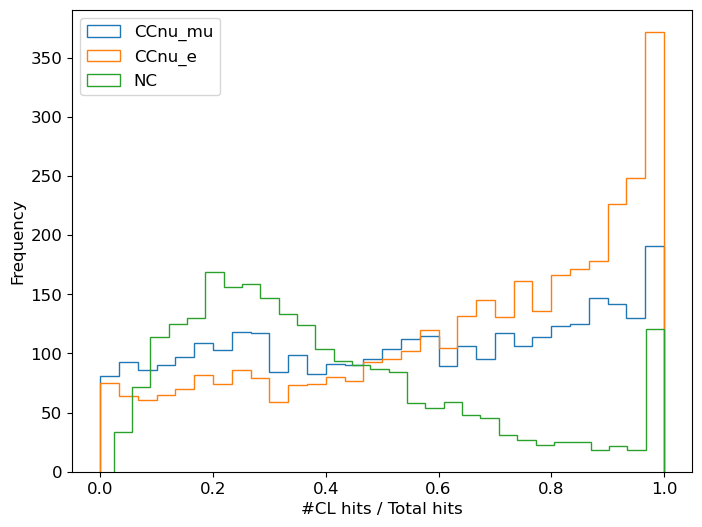

In [17]:
histogram(cheated_0, adc_ratio)